Versions:
* v1: Nepal Data, EMA implementation start. First working test with EMA

In [32]:
# Standard imports
import random
import pandas as pd
import numpy as np

# Own Model import
from lib.fl_model_v1 import *

#for nondominated sorting
import lib.pareto as pareto

# FL Model test

In [2]:
# For direct input model
nr_of_SPs = 1
nr_of_DPs = 5
nr_of_FLs = 6
nr_nodes = nr_of_SPs + nr_of_DPs + nr_of_FLs
areasize = 10

# Disruptions for each node

# DSR = Disruption Demand Points
# .5, 1.5: 50% of the time more or less, for traveling that distance
DSRDP = {"DSRDP{}".format(i): random.uniform (.5, 1.5) for i in range(nr_of_DPs)}
DSRFL = {"DSRFL{}".format(i): random.uniform (.5, 1.5) for i in range(nr_of_FLs)}

# Coordinates
SPX = {"SPX{}".format(i): random.uniform(0,areasize) for i in range(nr_of_SPs)}
SPY = {"SPY{}".format(i): random.uniform(0,areasize) for i in range(nr_of_SPs)}
DPX = {"DPX{}".format(i): random.uniform(0,areasize) for i in range(nr_of_DPs)}
DPY = {"DPY{}".format(i): random.uniform(0,areasize) for i in range(nr_of_DPs)}
FLX = {"FLX{}".format(i): random.uniform(0,areasize) for i in range(nr_of_FLs)}
FLY = {"FLY{}".format(i): random.uniform(0,areasize) for i in range(nr_of_FLs)}

FLO={"FLO0":1,"FLO1":1 ,"FLO2":0,"FLO3":1,"FLO4":0,"FLO5":0}

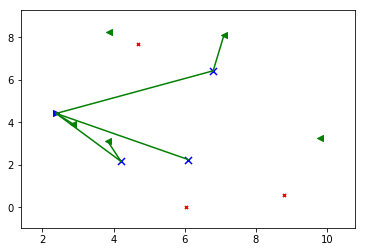

(762.6302361870196, 2, 20.0, 0.2340089078995329, 3)

In [3]:
# costs, nr_uncovered_DPs, total_uncovered_demand, total_distr_time, nr_op_fls = 
FL_model(
    100,
    1,
    True,
    FL_range=2,
    dist_method="euclidean",
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **FLO,
    **DSRDP,
    **DSRFL)

# FL Model Nepal

## Nepal Data

In [184]:
Nepal = pd.read_excel("Data/Nepal Cities Population.xlsx", usecols=[1,2,3,4])

# Take only larger cities, because of many null values under 50000 inhabitants. 
# TODO find better dataset with population and coordinates
Nepal = Nepal [Nepal.Population >= 50000]
Nepal.head(1)

,City,Population,Latitude (DD),Longitude (DD)
0,Kathmandu,743300,27.71,85.31


In [185]:
airports = pd.read_excel("Data/Nepal Airports.xlsx", usecols=[0,5,6])
int_airports = airports[airports['Airport'] == "Tribhuvan intl"]
int_airports.head()

,Airport,Latitude (DD),Longitude (DD)
7,Tribhuvan intl,27.7,85.36


## Nepal Instantiation 

In [6]:
# 0. Instantiate

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(Nepal['Latitude (DD)'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(Nepal['Longitude (DD)'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(int_airports['Latitude (DD)'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(int_airports['Longitude (DD)'])}

# Create random facility locations
# lon lat min:

long_min, lat_min, long_max, lat_max = 80, 25.767, 88.183, 30.45

nr_of_FLs = 6
FLX = {"FLX{}".format(i): random.uniform(long_min,long_max) for i in range(nr_of_FLs)}
FLY = {"FLY{}".format(i): random.uniform(lat_min,lat_max) for i in range(nr_of_FLs)}
# # Uncertainties + Ranges
# # For direct input model
# nr_of_SPs = 1
# nr_of_DPs = 5

# nr_nodes = nr_of_SPs + nr_of_DPs + nr_of_FLs
# areasize = 10

# # Disruptions for each node

# DSR = Disruption Demand Points
# .5, 1.5: 50% of the time more or less, for traveling that distance
DSRDP = {"DSRDP{}".format(i): random.uniform (.5, 1.5) for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): random.uniform (.5, 1.5) for i in range(nr_of_FLs)}

# Decision Variables
FLO={"FLO0":0,"FLO1":0 ,"FLO2":0,"FLO3":0,"FLO4":0,"FLO5":0}

## Nepal Model Evaluator

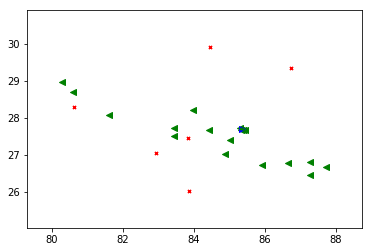

(844.0169777569713, 14, 140.0, 0.36457716303394555, 0)

In [7]:
FL_model(
    100,
    1,
    True,
    FL_range=10,
    dist_method="great_circle",
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **FLO,
    **DSRDP,
    **DSRFL)

# Multi-Objective Optimisation Framework

Pseudocode:

    Current situation
    Create possible options (full factorial)
    Evaluate all possible options
    Check pareto front of outcomes

In [21]:
current_situation = FLO
current_situation

{'FLO0': 0, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, 'FLO4': 0, 'FLO5': 0}

In [22]:
def create_policies(FL_dict, print_pols=False):
    """
    Takes the current network of Facility Locations and returns all possible policies for one added FL.
    
    Input: current option (Dict of FLs)
    Output: List of options (Dicts of FLs)
    """
    # All FL names
    FL_keys = sorted(FL_dict.keys())
    # All FL values indicating whether operational
    FL_values = [FL_dict[key] for key in FL_keys]
    
    i_operational_fls = i_FL_op = [i for i,x in enumerate(FL_values) if x == 1]
    
    # Create list of policies  
    pols = np.identity(len(FL_keys))
    # Set already operational facilities to operational
    pols[:,i_operational_fls] = 1
    
    #Delete policies where no new FLs are placed 
    new_n_operational_fls = sum(FL_values) + 1
    pols = pols[pols.sum(axis = 1) == new_n_operational_fls]

    
    # Return a list of dictionaries
    policy_list = []
    for pol in pols:
        policy_list.append({key:value for key,value in zip(FL_keys,pol)})
    
    if print_pols == True:
        print("total policies:",len(policy_list))
        for n,i in enumerate(policy_list):
            for v in i.values():
                print (int(v), end='')
            print(" <- policy {}".format(n))
                
    return policy_list

In [23]:
policies = create_policies(current_situation, print_pols=True)

total policies: 6
100000 <- policy 0
010000 <- policy 1
001000 <- policy 2
000100 <- policy 3
000010 <- policy 4
000001 <- policy 5


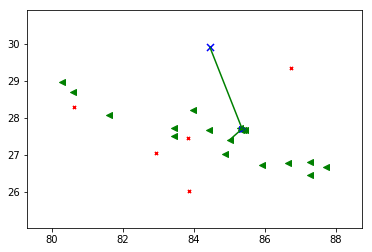

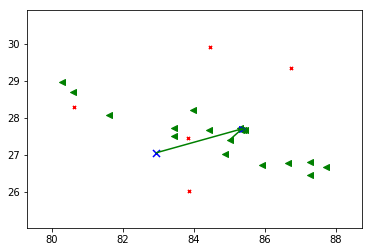

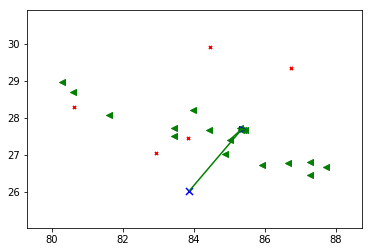

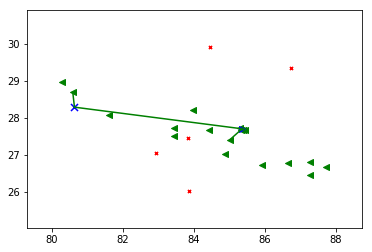

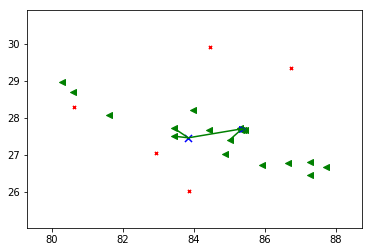

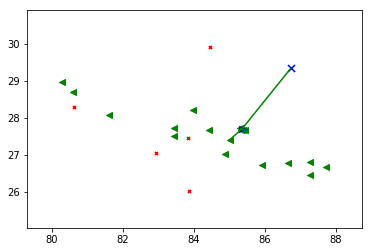

In [27]:
outcomes = []
for policy in policies:
    outcomes.append(FL_model(
    100,
    1,
    True,
    dist_method="great_circle",
    FL_range=50,
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **policy,
    **DSRDP,
    **DSRFL))

In [28]:
outcomes

[(16457.37596430194, 13, 130.0, 5.735400717424611, 1.0),
 (15923.705971297568, 13, 130.0, 5.55751071975649, 1.0),
 (15332.797795804066, 13, 130.0, 5.36054132792532, 1.0),
 (34967.733281195826, 12, 120.0, 9.859497516042897, 1.0),
 (21563.478580450246, 11, 110.0, 5.47244691932199, 1.0),
 (14761.719586296678, 13, 130.0, 5.170181924756192, 1.0)]

In [38]:
# Non-dominated sorting for outcomes
outcomes_df = pd.DataFrame(outcomes)

# options for pareto sorting
# minimising is default
kwargs = {"maximize_all":True}
kwargs2 = {"maximize":[0,1]}

nondominated = pareto.eps_sort([list(outcomes_df.itertuples(True))],[1,2,3,4,5], [1e-9,1e-9,1e-9,1e-9,1e-9])
nondominated

[[4, 21563.478580450246, 11, 110.0, 5.47244691932199, 1.0],
 [5, 14761.719586296678, 13, 130.0, 5.170181924756192, 1.0]]

In [61]:
# policies for all nondominated policies
i = [a[0] for a in nondominated]
policies = np.array(policies)
policies[i]

array([{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0},
       {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 1.0}],
      dtype=object)

# EMA Framework

In [62]:
from ema_workbench.em_framework import (Policy, IntegerParameter, Constant,
                                        RealParameter, ScalarOutcome,
                                        perform_experiments, Model)
from ema_workbench import ema_logging
# from ema_workbench.em_framework.

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [ ]:
Work this into ema framework

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(Nepal['Latitude (DD)'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(Nepal['Longitude (DD)'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(int_airports['Latitude (DD)'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(int_airports['Longitude (DD)'])}

# Create random facility locations
# lon lat min:

long_min, lat_min, long_max, lat_max = 80, 25.767, 88.183, 30.45

nr_of_FLs = 6
FLX = {"FLX{}".format(i): random.uniform(long_min,long_max) for i in range(nr_of_FLs)}
FLY = {"FLY{}".format(i): random.uniform(lat_min,lat_max) for i in range(nr_of_FLs)}
# # Uncertainties + Ranges
# # For direct input model
# nr_of_SPs = 1
# nr_of_DPs = 5

# nr_nodes = nr_of_SPs + nr_of_DPs + nr_of_FLs
# areasize = 10

# # Disruptions for each node

# DSR = Disruption Demand Points
# .5, 1.5: 50% of the time more or less, for traveling that distance
DSRDP = {"DSRDP{}".format(i): random.uniform (.5, 1.5) for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): random.uniform (.5, 1.5) for i in range(nr_of_FLs)}

# Decision Variables
FLO={"FLO0":0,"FLO1":0 ,"FLO2":0,"FLO3":0,"FLO4":0,"FLO5":0}

In [186]:
DPs = Nepal

In [187]:
SPs = int_airports

In [188]:
np.random.seed(0)
DPs['Demand_estimate'] = np.random.randint(0, 100, DPs.shape[0]) * DPs['Population']  # change random for impact factor
DPs['Demand_lower'] = DPs['Demand_estimate'] * 0.9
DPs['Demand_upper'] = DPs['Demand_estimate'] * 1.1
DPs['Demand_actual'] = np.random.uniform(DPs['Demand_lower'],DPs['Demand_upper'])
DPs['Demand_actual'] = DPs['Demand_actual'].apply(int)
DPs.head()

,City,Population,Latitude (DD),Longitude (DD),Demand_estimate,Demand_lower,Demand_upper,Demand_actual
0,Kathmandu,743300,27.71,85.31,32705200,29434680.0,35975720.0,32574229
1,Biratnagar,178000,26.46,87.28,8366000,7529400.0,9202600.0,8186607
2,Lalitpur,172400,27.68,85.32,11033600,9930240.0,12136960.0,11775231
3,Pokhara,169700,28.22,83.99,11369900,10232910.0,12506890.0,11000142
4,Birganj,119500,27.02,84.87,8006500,7205850.0,8807150.0,8243767


In [202]:
[(a,b) for a,b in enumerate(range(2))]

[(0, 0), (1, 1)]

In [204]:
[(i,city) for i,city in zip(DPs.index, DPs.City)]

[(0, 'Kathmandu'),
 (1, 'Biratnagar'),
 (2, 'Lalitpur'),
 (3, 'Pokhara'),
 (4, 'Birganj'),
 (5, 'Dharan'),
 (6, 'Bharatpur'),
 (7, 'Janakpur'),
 (8, 'Mahendranagar'),
 (9, 'Bhaktapur'),
 (10, 'Butwal'),
 (11, 'Hetauda'),
 (12, 'Dhangadhi'),
 (13, 'Nepalganj'),
 (14, 'Triyuga'),
 (15, 'Damak'),
 (16, 'Siddharthanagar'),
 (17, 'Madhyapur thimi')]

In [215]:
[
    Constant("DPX{}".format(i), x)
    for i, x in zip(DPs.index, DPs['Longitude (DD)'])
] + [
    Constant("DPY{}".format(i), y)
    for i, y in zip(DPs.index, DPs['Latitude (DD)'])
]

[Constant('DPX0', 85.31),
 Constant('DPX1', 87.28),
 Constant('DPX2', 85.32),
 Constant('DPX3', 83.99),
 Constant('DPX4', 84.87),
 Constant('DPX5', 87.26),
 Constant('DPX6', 84.44),
 Constant('DPX7', 85.92),
 Constant('DPX8', 80.3),
 Constant('DPX9', 85.43),
 Constant('DPX10', 83.45),
 Constant('DPX11', 85.02),
 Constant('DPX12', 80.59),
 Constant('DPX13', 81.62),
 Constant('DPX14', 86.641),
 Constant('DPX15', 87.73),
 Constant('DPX16', 83.45),
 Constant('DPX17', 85.38),
 Constant('DPY0', 27.71),
 Constant('DPY1', 26.46),
 Constant('DPY2', 27.68),
 Constant('DPY3', 28.22),
 Constant('DPY4', 27.02),
 Constant('DPY5', 26.81),
 Constant('DPY6', 27.67),
 Constant('DPY7', 26.73),
 Constant('DPY8', 28.96),
 Constant('DPY9', 27.67),
 Constant('DPY10', 27.71),
 Constant('DPY11', 27.41),
 Constant('DPY12', 28.69),
 Constant('DPY13', 28.07),
 Constant('DPY14', 26.7807),
 Constant('DPY15', 26.66),
 Constant('DPY16', 27.5),
 Constant('DPY17', 27.67)]

In [232]:
models = []
t = 0
model = Model("flmodelt{}".format(t), FL_model)


model.locations = [
    Constant("DPX{}".format(i), x)
    for i, x in zip(DPs.index, DPs['Longitude (DD)'])
] + [
    Constant("DPY{}".format(i), y)
    for i, y in zip(DPs.index, DPs['Latitude (DD)'])
]


model.constants = [
    Constant('graphical_representation', True),
    Constant('dist_method', 'great_circle'),
    Constant('Error_Test', 1), # this doesn't do anything. 
    #list of other constants
    #     Constant
] + model.locations



model.locations_uncertain = [
    RealParameter("SPX{}".format(i), 0, areasize) for i in range(nr_of_SPs)
] + [
    RealParameter("SPY{}".format(i), 0, areasize) for i in range(nr_of_SPs)
] + [
    RealParameter("FLX{}".format(i), 0, areasize) for i in range(nr_of_FLs)
] + [RealParameter("FLY{}".format(i), 0, areasize) for i in range(nr_of_FLs)]


# Reachability of Demand Points and Facility Locations can be disrupted
model.disruptions = [
    RealParameter("DSRFL{}".format(i), -0.5, 0.5) for i in range(nr_of_FLs)
] + [RealParameter("DSRDP{}".format(i), -0.5, 0.5) for i in range(DPs.shape[0])]

model.uncertainties = [
    RealParameter('unit_opening_costs', 100, 200),
    RealParameter('unit_transport_cost', 0.5,
                  2),  # cost of transporting one unit of relief goods
    RealParameter('FL_range', 2, 30),  # km TODO: great circle distance
    RealParameter(
        'lorry_speed', 30, 60
    ),  # km/h. Speed is Average speed. Constant, because roads are individually disrupted 
    #list of other uncertainties
] + model.disruptions + model.locations_uncertain

models.append(model)

In [81]:
for model in models:
    print(model.name)

flmodelt0


In [60]:
def create_ema_policies (FLs, )

SyntaxError: invalid syntax (<ipython-input-60-159aa41f105f>, line 1)

In [228]:
test_pol = policies[i][0]
Policy("test_pol",**test_pol)

{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0}

[MainProcess/INFO] performing 4 scenarios * 1 policies * 1 model(s) = 4 experiments
[MainProcess/INFO] performing experiments sequentially


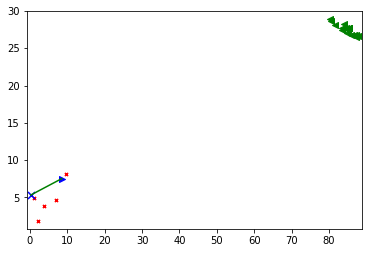

[MainProcess/INFO] 1 cases completed


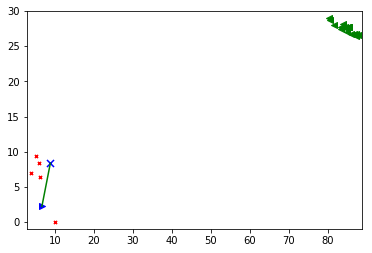

[MainProcess/INFO] 2 cases completed


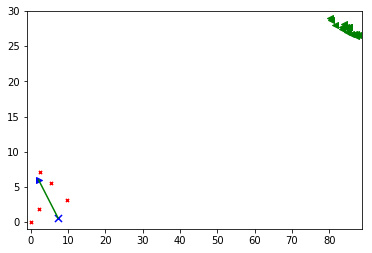

[MainProcess/INFO] 3 cases completed


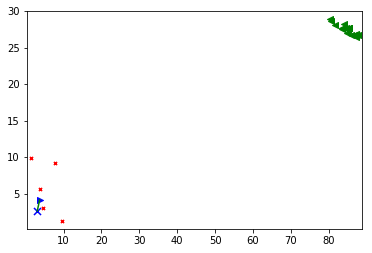

[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] experiments finished


(array([(-0.27128423,  0.20619943,  0.35243155,  0.03916337, -0.464921  , -0.34994678,  0.19018589,  0.44909919, -0.42752164, -0.00906475,  0.11209229, -0.30920875, -0.2351542 ,  0.0411221 , -0.35837347, -0.11005644, -0.06860662,  0.27493324, -0.45886682,  0.34880831, -0.42027067, -0.33375882, -0.22212599, -0.48191241, 3.76578056, 6.97615572, 9.80574626, 1.03758154, 0.24419092, 2.30067939, 3.80020354, 4.67063746, 8.10919469, 4.87135075, 5.32174153, 1.79847266, 16.30811454, 8.57528996, 7.53466262, 39.82971914, 192.13537332, 1.98706874, 18, 'test_pol', 'flmodelt0'),
        ( 0.01233724,  0.41715146,  0.09337775, -0.07896857,  0.33974882,  0.49079932, -0.41022234, -0.43339802,  0.39442736,  0.46965009, -0.3580385 ,  0.32787152,  0.46900671, -0.06294401, -0.15802063,  0.14116663,  0.00963931, -0.13110272,  0.37822633,  0.07770999,  0.24364716, -0.06152748, -0.38525753,  0.32002844, 9.99952145, 3.78748229, 6.23090352, 5.08013905, 8.7873055 , 5.9156108 , 0.07665262, 6.98746947, 6.4715975 , 

In [233]:
perform_experiments(model,4,Policy("test_pol",**test_pol))

# Robustness Framework

# Next iteration Framework